In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#ff33aa; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
!pip install --upgrade pip --user --quiet --no-warn-script-location
!pip install --upgrade neural_structured_learning --user --quiet

In [3]:
dhtml('Code Modules & Settings')

In [4]:
import os,numpy as np,pandas as pd
import pylab as pl,seaborn as sn,tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image as tkimg
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as tkl,callbacks as tkc
import neural_structured_learning as nsl

In [5]:
dhtml('Mixed Data')

In [6]:
classes=['plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck']
(x,y),(_,_)=cifar10.load_data()
x=np.array(x,dtype='float32')/255
y=y.reshape(-1)
n_photo=1200; N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
shuffle_ids=shuffle_ids[:n_photo]
x,y=x[shuffle_ids],y[shuffle_ids]

170500096/170498071 [==============================] - 5s 0us/step


[(1200, 32, 32, 3), dtype('float32'), (1200,), dtype('uint8')]
Label:  horse


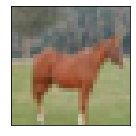

In [7]:
print([x.shape,x.dtype,y.shape,y.dtype])
print('Label: ',classes[y[1]])
pl.figure(figsize=(2,2))
pl.xticks([]); pl.yticks([])
pl.tight_layout(); pl.imshow(x[1]);

In [8]:
img_size=32
manners=['pictogram','contour','sketch']
objects=['flower','bird','butterfly','tree',
         'plane','crane','dog','horse',
         'deer','truck','car','cat',
         'frog','ship','fish','house']
file_path='../input/art-pictogram/pictograms/'
file_list=sorted(os.listdir(file_path))
def paths2tensor(img_paths,file_path=file_path,
                 img_size=img_size):
    tensor=[]
    for img_path in tqdm(img_paths):
        img0=tkimg.load_img(
            file_path+img_path,target_size=(img_size,img_size))
        img=tkimg.img_to_array(img0)
        tensor.append(np.expand_dims(img,axis=0))
    return np.vstack(tensor)
labels1=np.array([int(el[:2]) for el in file_list],dtype='int16')-1
labels2=np.array([int(el[3:6]) for el in file_list],dtype='int16')-1
images=np.array(paths2tensor(file_list))/255
n_draw=len(labels1[labels1==0])
images=images[:n_draw]; labels2=labels2[:n_draw]
cond=np.where([l in classes for l in objects])[0]
cond2=np.where([l in cond for l in labels2])
images=images[cond2]; labels=labels2[cond2]
rd={1:2,4:0,6:5,7:7,8:4,9:9,10:1,11:3,12:6,13:8}
labels=np.array([rd.get(x,x) for x in labels],dtype='float32')

100%|██████████| 3545/3545 [00:21<00:00, 167.04it/s]


[(1169, 32, 32, 3), dtype('float32'), (1169,), dtype('float32')]
Label:  bird


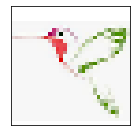

In [9]:
print([images.shape,images.dtype,
       labels.shape,labels.dtype])
print('Label: ',classes[int(labels[100])])
pl.figure(figsize=(2,2))
pl.xticks([]); pl.yticks([])
pl.tight_layout(); pl.imshow(images[100]);

In [10]:
x=np.vstack([x,images]); y=np.hstack([y,labels])
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
print([x.shape,x.dtype,y.shape,y.dtype])

[(2369, 32, 32, 3), dtype('float32'), (2369,), dtype('float32')]


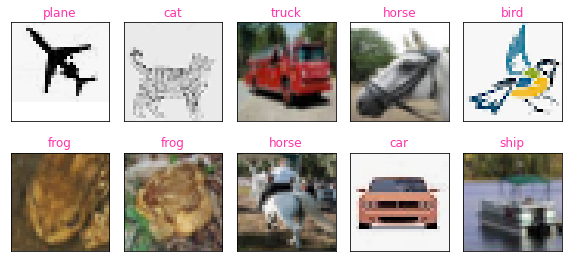

In [11]:
fig=pl.figure(figsize=(8,4))
randi=np.random.choice(
    x_test.shape[0],size=10,replace=False)
for i,idx in enumerate(randi):
    ax=fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(x_test[idx])
    true_idx=int(y_test[idx])
    ax.set_title(classes[true_idx],color="#ff33aa")
    pl.tight_layout();

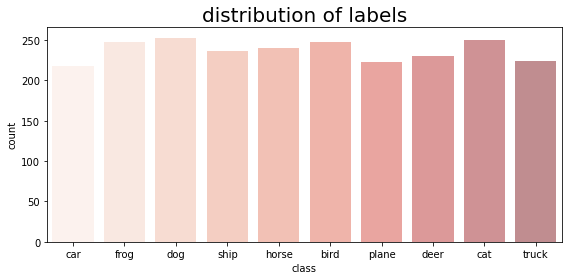

In [12]:
df=pd.DataFrame(y,columns=['label'])
df['class']=[classes[int(l)] for l in y]
pl.figure(figsize=(8,4))
sn.countplot(x='class',data=df,palette='Reds',alpha=.5)
pl.title('distribution of labels',fontsize=20)
pl.tight_layout();

In [13]:
dhtml('NN Examples')

In [14]:
def cnn_model():
    model=Sequential()
    model.add(tkl.Conv2D(32,(5,5),padding='same',
                         input_shape=x_train.shape[1:]))
    model.add(tkl.Activation('relu'))
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(96,(5,5)))
    model.add(tkl.Activation('relu'))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.GlobalAveragePooling2D())    
    model.add(tkl.Dense(1024,activation='relu'))
    model.add(tkl.Dropout(.5))         
 #   model.add(tkl.Dense(128,activation='relu'))
 #   model.add(tkl.Dropout(.25)) 
    model.add(tkl.Dense(10))
    model.add(tkl.Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
cnn_model=cnn_model()

In [15]:
model_weights='/tmp/checkpoint'
early_stopping=tkc.EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(
    filepath=model_weights,verbose=2,save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
history=cnn_model.fit(
    x_train,y_train,epochs=100,batch_size=64,verbose=2,
    validation_data=(x_valid,y_valid),
    callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.07203, saving model to /tmp/checkpoint
30/30 - 3s - loss: 2.3024 - accuracy: 0.1075 - val_loss: 2.2949 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.07203 to 0.10169, saving model to /tmp/checkpoint
30/30 - 3s - loss: 2.2573 - accuracy: 0.1444 - val_loss: 2.2756 - val_accuracy: 0.1017 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.10169 to 0.25424, saving model to /tmp/checkpoint
30/30 - 3s - loss: 2.1810 - accuracy: 0.1782 - val_loss: 2.0609 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_accuracy did not improve from 0.25424
30/30 - 2s - loss: 2.0971 - accuracy: 0.2098 - val_loss: 2.0741 - val_accuracy: 0.2373 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.25424 to 0.28390, saving model to /tmp/checkpoint
30/30 - 2s - loss: 2.0036 - accuracy: 0.2409 - val_loss: 1.9375 - val_accuracy: 0.2839 - lr: 0.0010
Epoch 6/100

Ep

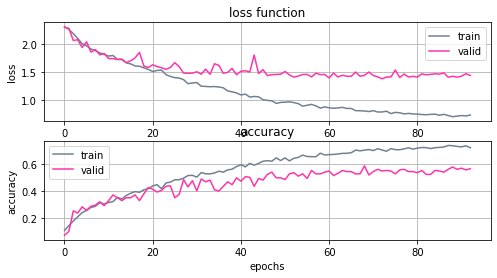

In [16]:
def history_plot(fit_history):
    pl.figure(figsize=(8,4)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#ff33aa',label='valid')
    pl.xlabel('epochs'); pl.ylabel('loss')
    pl.legend(); pl.grid()
    pl.title('loss function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#ff33aa',label='valid')
    pl.xlabel('epochs'); pl.ylabel('accuracy')    
    pl.legend(); pl.grid()
    pl.title('accuracy'); pl.show()
history_plot(history)

In [17]:
cnn_model.load_weights(model_weights)
dhtml(cnn_model.evaluate(x_test,y_test,verbose=0))

In [18]:
batch_size=64; img_size=32; n_classes=10; epochs=30
base_model=tf.keras.Sequential([
    tf.keras.Input((img_size,img_size,3),name='input'),
    tf.keras.layers.Conv2D(32,(5,5),padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Conv2D(196,(5,5)),
    tf.keras.layers.Activation('relu'),    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.GlobalMaxPooling2D(),    
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(n_classes,activation='softmax')
])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
model_weights='/tmp/checkpoint'
checkpointer=tkc.ModelCheckpoint(
    filepath=model_weights,verbose=2,save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',save_best_only=True)
adv_model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')

In [19]:
train=tf.data.Dataset.from_tensor_slices(
    {'input':x_train,'label':y_train}).batch(batch_size)
valid=tf.data.Dataset.from_tensor_slices(
    {'input':x_valid,'label':y_valid}).batch(batch_size)
valid_steps=x_valid.shape[0]//batch_size
adv_model.fit(train,epochs=epochs,verbose=2,callbacks=[checkpointer],
              validation_data=valid,validation_steps=valid_steps);

Epoch 1/30

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.07292, saving model to /tmp/checkpoint
30/30 - 9s - loss: 2.7749 - sparse_categorical_crossentropy: 2.3130 - sparse_categorical_accuracy: 0.1086 - scaled_adversarial_loss: 0.4619 - val_loss: 2.7624 - val_sparse_categorical_crossentropy: 2.3018 - val_sparse_categorical_accuracy: 0.0729 - val_scaled_adversarial_loss: 0.4606
Epoch 2/30

Epoch 00002: val_sparse_categorical_accuracy improved from 0.07292 to 0.15625, saving model to /tmp/checkpoint
30/30 - 9s - loss: 2.7568 - sparse_categorical_crossentropy: 2.2974 - sparse_categorical_accuracy: 0.1133 - scaled_adversarial_loss: 0.4594 - val_loss: 2.7474 - val_sparse_categorical_crossentropy: 2.2891 - val_sparse_categorical_accuracy: 0.1562 - val_scaled_adversarial_loss: 0.4582
Epoch 3/30

Epoch 00003: val_sparse_categorical_accuracy improved from 0.15625 to 0.23438, saving model to /tmp/checkpoint
30/30 - 9s - loss: 2.6910 - sparse_categorical_crossentropy: 2.2

In [20]:
dhtml(adv_model.evaluate({'input':x_test,'label':y_test},verbose=0))